
# Análisis descriptivo, tratamiento de valores faltantes y variables categóricas


## Importar datos

Cargamos las librerías necesarias.
- `pandas` y `numpy` para manipulación de datos,
- `matplotlib` para visualizaciones,
- `sklearn` para imputación y One-Hot Encoding.


In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer



## 1) Carga del CSV (`datos.csv` con separador `;`)


In [2]:
df = pd.read_csv("spotify-2023.csv")
df


,track_name,artist(s)_name,released_year,streams,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Que Vuelvas,"Carin Leon, Grupo Frontera",2022,2762,49,78,64,19,0,11,4
1,Jhoome Jo Pathaan,"Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...",2022,1365184,82,62,74,10,0,33,7
2,QUEMA,"Sog, Ryan Castro, Peso Pluma",2023,11599388,79,92,89,5,0,6,5
3,"Gol Bolinha, Gol Quadrado 2","Mc Pedrinho, DJ 900",2023,11956641,93,68,65,42,0,12,25
4,Overdrive,Post Malone,2023,14780425,56,48,73,0,0,35,4
...,...,...,...,...,...,...,...,...,...,...,...
947,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2018,2808096550,76,91,50,54,0,7,5
948,Dance Monkey,Tones and I,2019,2864791672,82,54,59,69,0,18,10
949,Someone You Loved,Lewis Capaldi,2018,2887241814,50,45,41,75,0,11,3
950,Shape of You,Ed Sheeran,2017,3562543890,83,93,65,58,0,9,8



## 2) Inspección inicial

Preguntas guía:
- ¿Cuántas observaciones y variables hay?
- ¿Qué tipos de datos tenemos (numéricos, cadenas/objetos, fechas)?
- ¿Hay columnas con un único valor o muchas categorías?


In [3]:

print("Dimensiones:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras filas:")
display(df.head())

print("\nValores únicos aproximados por columna (hasta 20 ejemplos):")
for col in df.columns:
    uniq = df[col].unique()
    print(f"- {col}: {len(uniq)} únicos. Valores:", uniq[:20])


Dimensiones: (952, 11)

Tipos de datos:
track_name            object
artist(s)_name        object
released_year          int64
streams                int64
danceability_%         int64
valence_%              int64
energy_%               int64
acousticness_%         int64
instrumentalness_%     int64
liveness_%             int64
speechiness_%          int64
dtype: object

Primeras filas:


,track_name,artist(s)_name,released_year,streams,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Que Vuelvas,"Carin Leon, Grupo Frontera",2022,2762,49,78,64,19,0,11,4
1,Jhoome Jo Pathaan,"Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...",2022,1365184,82,62,74,10,0,33,7
2,QUEMA,"Sog, Ryan Castro, Peso Pluma",2023,11599388,79,92,89,5,0,6,5
3,"Gol Bolinha, Gol Quadrado 2","Mc Pedrinho, DJ 900",2023,11956641,93,68,65,42,0,12,25
4,Overdrive,Post Malone,2023,14780425,56,48,73,0,0,35,4



Valores únicos aproximados por columna (hasta 20 ejemplos):
- track_name: 941 únicos. Valores: ['Que Vuelvas' 'Jhoome Jo Pathaan' 'QUEMA' 'Gol Bolinha, Gol Quadrado 2'
 'Overdrive' 'S91' 'Rush' 'Danger (Spider) (Offset & JID)' 'New Jeans'
 "Better Than Revenge (Taylor's Version)"
 'What Was I Made For? [From The Motion Picture "Barbie"]'
 'Mi Bello Angel' 'Phantom Regret by Jim' 'Devil Don'
 'Link Up (Metro Boomin & Don Toliver, Wizkid feat. BEAM & Toian) - Spider-Verse Remix (Spider-Man: Across the Spider-Verse )'
 'Mother I Sober (feat. Beth Gibbons of Portishead)'
 'Born With A Beer In My Hand' "Don't ever say love me (feat. RM of BTS)"
 "Mine (Taylor's Version)" 'Savior - Interlude']
- artist(s)_name: 644 únicos. Valores: ['Carin Leon, Grupo Frontera'
 'Arijit Singh, Vishal Dadlani, Sukriti Kakar, Vishal-Shekhar, Shekhar Ravjiani, Kumaar'
 'Sog, Ryan Castro, Peso Pluma' 'Mc Pedrinho, DJ 900' 'Post Malone'
 'Karol G' 'Troye Sivan' 'Offset, JID' 'NewJeans' 'Taylor Swift'
 'Billie Ei


## 3) Análisis descriptivo

- Estadísticos básicos para variables **numéricas** con `describe()`.
- Resumen de frecuencias para variables **categóricas** (tipo `object`/`category`).

> Nota: Si tienes valores numéricos almacenados como texto con comas/puntos, considera convertirlos previamente.


In [4]:

print("Estadísticos descriptivos (numéricos):")
display(df.select_dtypes(include=[np.number]).describe().T)

print("\nFrecuencias de las 10 categorías más comunes por columna categórica:")
cat_cols_raw = df.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols_raw:
    print(f"\nColumna: {col}")
    display(df[col].value_counts(dropna=False).head(10))


Estadísticos descriptivos (numéricos):


,count,mean,std,min,25%,50%,75%,max
released_year,952.0,2.018289e+03,1.101140e+01,1930.0,2020.0,2022.0,2022.0,2.023000e+03
streams,952.0,5.141374e+08,5.668569e+08,2762.0,141636175.0,290530915.0,673869022.0,3.703895e+09
danceability_%,952.0,6.698424e+01,1.463128e+01,23.0,57.0,69.0,78.0,9.600000e+01
valence_%,952.0,5.140651e+01,2.348053e+01,4.0,32.0,51.0,70.0,9.700000e+01
energy_%,952.0,6.427416e+01,1.655852e+01,9.0,53.0,66.0,77.0,9.700000e+01
acousticness_%,952.0,2.707878e+01,2.600160e+01,0.0,6.0,18.0,43.0,9.700000e+01
instrumentalness_%,952.0,1.582983e+00,8.414064e+00,0.0,0.0,0.0,0.0,9.100000e+01
liveness_%,952.0,1.821429e+01,1.371837e+01,3.0,10.0,12.0,24.0,9.700000e+01
speechiness_%,952.0,1.013866e+01,9.915399e+00,2.0,4.0,6.0,11.0,6.400000e+01



Frecuencias de las 10 categorías más comunes por columna categórica:

Columna: track_name


track_name
SPIT IN MY FACE!    2
Numb                2
Die For You         2
SNAP                2
Miss You            2
Take My Breath      2
About Damn Time     2
NaN                 2
Daylight            2
Flowers             2
Name: count, dtype: int64


Columna: artist(s)_name


artist(s)_name
Taylor Swift        34
The Weeknd          22
Bad Bunny           19
SZA                 19
Harry Styles        17
Kendrick Lamar      12
Morgan Wallen       11
Ed Sheeran           9
Feid                 8
Drake, 21 Savage     8
Name: count, dtype: int64


### Visualizaciones rápidas

Reglas:
- Usamos `matplotlib`.
- **Una gráfica por celda**.
- **Sin estilos ni colores específicos**.

1. Histograma de la **primera columna numérica**.


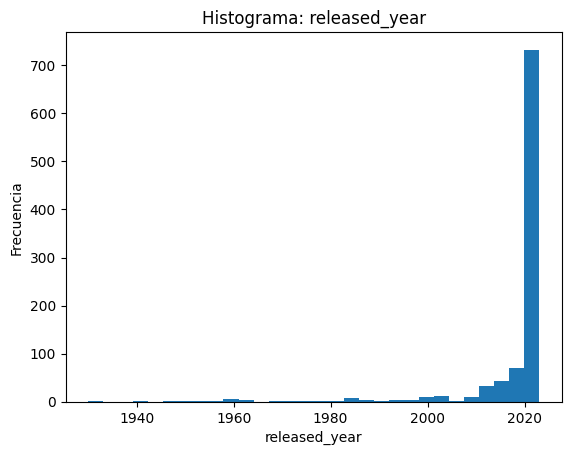

In [5]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure()
df[num_cols[0]].plot(kind='hist', bins=30, title=f'Histograma: {num_cols[0]}')
plt.xlabel(num_cols[0])
plt.ylabel('Frecuencia')
plt.show()




2. Boxplot de la **segunda columna numérica** (si existe).


<Figure size 640x480 with 0 Axes>

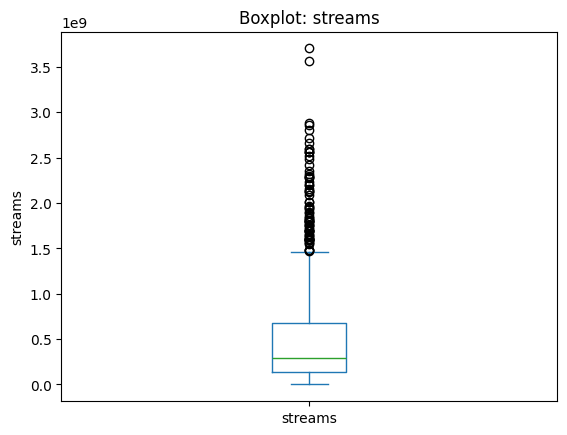

In [6]:

plt.figure()
df[[num_cols[1]]].plot(kind='box', title=f'Boxplot: {num_cols[1]}')
plt.ylabel(num_cols[1])
plt.show()



## 4) Detección de valores faltantes

Aquí calculamos el conteo de `NaN` por columna y el porcentaje de faltantes.


In [7]:

na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)

print("Top columnas con más faltantes:")
display(pd.DataFrame({'faltantes': na_counts, 'porcentaje': na_pct}).head(20))


Top columnas con más faltantes:


,faltantes,porcentaje
track_name,2,0.210084
artist(s)_name,0,0.000000
released_year,0,0.000000
streams,0,0.000000
danceability_%,0,0.000000
valence_%,0,0.000000
energy_%,0,0.000000
acousticness_%,0,0.000000
instrumentalness_%,0,0.000000
liveness_%,0,0.000000



## 5) Imputación de valores faltantes

Estrategia simple (puedes ajustarla):
- Para **numéricos**: imputar con **mediana** (más robusta a outliers que la media).
- Para **categóricos**: imputar con **moda** (valor más frecuente).


In [8]:

df_impute = df.copy()

num_cols = df_impute.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_impute.select_dtypes(include=['object','category']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

if num_cols:
    df_impute[num_cols] = num_imputer.fit_transform(df_impute[num_cols])
if cat_cols:
    df_impute[cat_cols] = cat_imputer.fit_transform(df_impute[cat_cols])

print("Comprobación de faltantes tras imputación:")
display(df_impute.isna().sum().sort_values(ascending=False).head(10))


Comprobación de faltantes tras imputación:


track_name            0
artist(s)_name        0
released_year         0
streams               0
danceability_%        0
valence_%             0
energy_%              0
acousticness_%        0
instrumentalness_%    0
liveness_%            0
dtype: int64


## 6) Variables dummies

Dos caminos:
1. **`pandas.get_dummies`** (rápido) con `drop_first=True` para evitar colinealidad perfecta.  
2. **`sklearn.OneHotEncoder`** dentro de un `Pipeline` + `ColumnTransformer` (útil para modelado).

Primero, normalizamos tipos categóricos a `category`.


In [9]:

df_feat = df_impute.copy()

# Asegurar tipo categórico
for c in cat_cols:
    df_feat[c] = df_feat[c].astype('category')

# 6.1 Dummies con pandas
df_dummies_pd = pd.get_dummies(df_feat, columns=cat_cols, drop_first=True)
print("Columnas añadidas (muestra) con get_dummies:")
display([c for c in df_dummies_pd.columns if any(c.startswith(col+'_') for col in cat_cols)][:20])
display(df_dummies_pd.head())


Columnas añadidas (muestra) con get_dummies:


['track_name_(It Goes Like) Nanana - Edit',
 'track_name_10 Things I Hate About You',
 'track_name_10:35',
 'track_name_2 Be Loved (Am I Ready)',
 'track_name_2055',
 'track_name_212',
 'track_name_25k jacket (feat. Lil Baby)',
 'track_name_295',
 'track_name_505',
 'track_name_69',
 'track_name_98 Braves',
 'track_name_A Holly Jolly Christmas - Single Version',
 'track_name_A Tale By Quincy',
 'track_name_A Tu Merced',
 'track_name_A Veces (feat. Feid)',
 'track_name_ALIEN SUPERSTAR',
 'track_name_AM Remix',
 'track_name_AMARGURA',
 'track_name_AMERICA HAS A PROBLEM (feat. Kendrick Lamar)',
 'track_name_AMG']

,released_year,streams,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,track_name_(It Goes Like) Nanana - Edit,...,artist(s)_name_Zion & Lennox,artist(s)_name_a-ha,artist(s)_name_d4vd,"artist(s)_name_dennis, MC Kevin o Chris",artist(s)_name_girl in red,artist(s)_name_j-hope,"artist(s)_name_j-hope, J. Cole",artist(s)_name_sped up 8282,"artist(s)_name_sped up nightcore, ARIZONATEARS, Lil Uzi Vert",artist(s)_name_teto
0,2022.0,2762.0,49.0,78.0,64.0,19.0,0.0,11.0,4.0,False,...,False,False,False,False,False,False,False,False,False,False
1,2022.0,1365184.0,82.0,62.0,74.0,10.0,0.0,33.0,7.0,False,...,False,False,False,False,False,False,False,False,False,False
2,2023.0,11599388.0,79.0,92.0,89.0,5.0,0.0,6.0,5.0,False,...,False,False,False,False,False,False,False,False,False,False
3,2023.0,11956641.0,93.0,68.0,65.0,42.0,0.0,12.0,25.0,False,...,False,False,False,False,False,False,False,False,False,False
4,2023.0,14780425.0,56.0,48.0,73.0,0.0,0.0,35.0,4.0,False,...,False,False,False,False,False,False,False,False,False,False



## 7) Exportación del dataset limpio

Guardamos dos versiones:
- `datos_limpios.csv` a partir de **get_dummies (pandas)**.


In [10]:

df_dummies_pd.to_csv("datos_limpios.csv", index=False)
